In [1]:
#import ipdb # alternative to pdb that works in jupyter notebook (pip3 install ipdb)
import os, subprocess, sys, re, time
from pathlib import Path
from pynq import Overlay
#from pynq import GPIO
from pynq import allocate

from dma_receiver import DmaReceiver
from bram_loader import Bram_Loader

#BASE_DIR = Path('/home/xilinx/Django/pynq')
#PATH = BASE_DIR / 'tools/make'

BASE_DIR = Path('/home/xilinx/design_files')
PATH = BASE_DIR 

#base = Overlay(str(BASE_DIR / 'core_RV32ACIMU_flute_modified.bit'))
#base = Overlay(str(BASE_DIR / 'onboard.bit'))
base = Overlay(str(BASE_DIR / 'p2.bit'))

ITEM_BYTE_SIZE = 8
FIFO_SIZE = 32768
# +4 because DMA seems to have it's own buffer it fills before dma.recvchannel.transfer is even called
buffer_length = min( base.axi_dma_0.buffer_max_size // ITEM_BYTE_SIZE, FIFO_SIZE)# + 4) 

print('buffer_length =', buffer_length)
input_buffer = allocate(shape=(buffer_length,), dtype='u8')
input_buffer_2 = allocate(shape=(buffer_length,), dtype='u8')

#dma_receiver = DmaReceiver(base.axi_dma_0, items_limit=2500, buffer_count=4, allocate_kwargs={'shape':(buffer_length,), 'dtype':'u8'})

#def unpack_packet(pkt):
#    ''' Single packet/item (128-bit) in FIFO represents 2 values, 
#    program counter (64-bit) and instruction (64-bit, should be 32-bit btw but this will be changed later). '''
#    pc = int(pkt) >> 32;
#    instr = int(pkt) & 0xffffffff;
#    return (pc, instr)

#boot_mem = base.axi_bram_ctrl_1
#prog_mem = base.axi_bram_ctrl_3

dma_rec = base.axi_dma_0.recvchannel
#dma_rec_2 = base.axi_dma_1.recvchannel
#dma_send = base.axi_dma_0.sendchannel

# https://pynq.readthedocs.io/en/v2.7.0/_modules/pynq/lib/axigpio.html
gpio_rst_n_out = base.axi_gpio_0.channel1[0]
gpio_en_cpu_reset_server_request_put_out = base.axi_gpio_0.channel1[1]
#gpio_function_trace_rst = base.axi_gpio_0.channel1[2]
gpio_pc_stream_m_axis_select = base.axi_gpio_0.channel1[3]
#gpio_pc_stream_m_axis_select.write(1) # had to initialize it to 1 in simulation
gpio_pc_stream_m_axis_tlast_interval = base.axi_gpio_1.channel1
fifo_select = 0
gpio_pc_stream_m_axis_select.write(fifo_select)

gpio_fifo_wr_count = base.axi_gpio_0.channel2[0:16]
gpio_fifo_rd_count = base.axi_gpio_0.channel2[16:32]
#gpio_function_trace_rst_n_out = base.axi_gpio_0.channel1[2]


def print_dma_channel_status(channel):
    print('dma.running =', channel.running)
    print('dma.idle =', channel.idle)
    print('dma.error =', channel.error)
    print('status =', hex(channel._mmio.read(channel._offset + 4)))

def switch_fifo():
    global fifo_select
    ''' Start filling the other FIFO while the current one is being read
        using dma.recvchannel.transfer(buffer_of_fifo_len_plus_4).
        If the fifo is being filled during transfer, it results in error,
        the error is described at:
        https://discuss.pynq.io/t/reliable-transfer-from-axi4-stream-data-fifo-using-axi-dma/4518
        '''
    #state = gpio_pc_stream_m_axis_select.read()
    #new_state = state ^ 1 # XOR 1 (flip)
    fifo_select ^= 1
    gpio_pc_stream_m_axis_select.write(fifo_select)

def verify_mem(bram_ctrl, offset, len_):
    m = bram_ctrl.mmio.array
    text_part = m[offset:offset+len_]
    s = ''
    for i in text_part:
        for c, c2 in zip(f'{i:08X}'[0::2], f'{i:08X}'[1::2]):
            s += chr(int(c+c2, 16))
    print('first instructions:', list(f'0x{v:08x}' for v in m[:2]))
    print('known string: ', s)
    print()


def reset_cpu(delay=0.001):
    gpio_en_cpu_reset_server_request_put_out.write(0)
    gpio_rst_n_out.write(0)
    time.sleep(delay)
    gpio_rst_n_out.write(1)
    time.sleep(delay)
    gpio_en_cpu_reset_server_request_put_out.write(1)
    time.sleep(delay)
    gpio_en_cpu_reset_server_request_put_out.write(0)
    time.sleep(delay)

def print_fifo_data_counts():
    print('gpio_fifo_wr_count =', gpio_fifo_wr_count.read())
    print('gpio_fifo_rd_count =', gpio_fifo_rd_count.read())
    
def set_pc_stream_tlast_interval(items_count):
    ''' Sets 32-bit value specifying how many items can 
    arrive by a single dma.recvchannel.tranfer(ib) call. '''
    gpio_pc_stream_m_axis_tlast_interval[0:32].write(items_count)
    
# in pynq 2.6 load_ip_data worked well
# in pynq 2.7 axi_bram_ctrl_1 is a "memory" instead of "defaultIP" (when checked with "base?")
# in pynq 2.7 load_ip_data results in KeyError but still loads the file correctly
def load_ip_data_workaround(ip_name, f_name):
    try:
        base.load_ip_data(ip_name, f_name)
    except KeyError:
        pass

def speed_test():
    def original_speed_test(n=5):
        data = []
        i = 0
        while len(data) < n:        
            i += 1
            dma_rec.transfer(input_buffer)
            dma_rec.wait()
            items_transferred = dma_rec.transferred // ITEM_BYTE_SIZE
            data.extend(input_buffer[0:items_transferred].tolist())
        return i

    def dma_receiver_speed_test(n=5):
        data = []
        i = 0
        while len(data) < n:  
            i += 1
            data.extend( dma_receiver.get() )
        return i

    start_time = time.time()
    iterations = original_speed_test(n=2000000)
    print('original took:', f'{time.time() - start_time}s (iterations={iterations})')

    dma_receiver = DmaReceiver(base.axi_dma_0, items_limit=1000000, buffer_count=2, allocate_kwargs={'shape':(buffer_length,), 'dtype':'u8'})

    start_time = time.time()
    iterations = dma_receiver_speed_test(n=2000000)
    print('DmaReceiver took:', f'{time.time() - start_time}s (iterations={iterations})')

def console_send(s):
    console_input = base.axi_gpio_3.channel1[0:8]
    console_write_enable = base.axi_gpio_3.channel1[8] # using "edge_detector" to avoid continuous writing
    console_write_enable.off()
    for c in s:
        console_input.write(ord(c))
        console_write_enable.on()
        console_write_enable.off()
    
def console_data_available():
    console_output_empty = base.axi_gpio_3.channel2[8]
    return console_output_empty.read() == 0

def console_read():
    s = ''
    console_output = base.axi_gpio_3.channel2[0:8]
    console_read_enable = base.axi_gpio_3.channel1[9] # using "edge_detector" to avoid continuous reading
    console_read_enable.off()
    while console_data_available():
        s += chr(console_output.read())
        console_read_enable.on()
        console_read_enable.off()
    return s
    
    
print_dma_channel_status(dma_rec)
#print_dma_channel_status(dma_send)
print_fifo_data_counts()

#load_ip_data_workaround('axi_bram_ctrl_bootrom', PATH / 'riscv-example.bin')
#load_ip_data_workaround('axi_bram_ctrl_3', PATH / 'rv64ui-p-add.bin')

#verify_mem(boot_mem, 7//4, 6)
#verify_mem(prog_mem, 0x200//4, 0x50//4)

set_pc_stream_tlast_interval(1000)


buffer_length = 32768
dma.running = True
dma.idle = False
dma.error = False
status = 0x0
gpio_fifo_wr_count = 0
gpio_fifo_rd_count = 0


In [2]:
gpio_rst_n_out.write(0)

In [3]:
bram_loader = Bram_Loader(base.axi_gpio_2)
bram_loader.load(PATH / 'riscv-example.bin')

In [4]:
m = base.axi_bram_ctrl_3.mmio.array

with open(PATH / 'rv64ui-p-add.bin', 'rb') as f:
    data = f.read()
    for i, _ in enumerate(data):
        if i % 4 > 0:
            continue
        byte = int.from_bytes(data[i:i+4], byteorder='little')
        m[i // 4] = byte

#m[0] = 0xabababab
print('first instructions:', list(f'0x{v:08x}' for v in m[:8]))
print('first instructions:', list(f'0x{v:08x}' for v in m[8:16]))

AttributeError: Could not find IP or hierarchy axi_bram_ctrl_3 in overlay

In [48]:
for i in range(24):
    m[i] = i

print('first instructions:', list(f'0x{v:08x}' for v in m[:8]))
print('first instructions:', list(f'0x{v:08x}' for v in m[8:16]))
print('first instructions:', list(f'0x{v:08x}' for v in m[16:24]))

first instructions: ['0x00000000', '0x00000009', '0x00000002', '0x00000003', '0x00000004', '0x00000005', '0x00000006', '0x00000007']
first instructions: ['0x00000008', '0x00000001', '0x00000002', '0x00000003', '0x00000004', '0x00000005', '0x00000006', '0x00000007']
first instructions: ['0x00000010', '0x00000009', '0x0000000a', '0x0000000b', '0x0000000c', '0x0000000d', '0x0000000e', '0x0000000f']


In [5]:
load_ip_data_workaround('axi_bram_ctrl_3', PATH / 'rv64ui-p-add.bin')

In [8]:
gpio_rst_n_out.write(0)
time.sleep(0.001)

#load_ip_data_workaround('axi_bram_ctrl_1', PATH / 'rv64ui-p-add.bin')
load_ip_data_workaround('axi_bram_ctrl_3', PATH / 'rv64ui-p-add.bin')
#m = prog_mem.mmio.array
#m = base.axi_bram_ctrl_3.mmio.array
print('first instructions:', list(f'0x{v:08x}' for v in m[:8]))
print('first instructions:', list(f'0x{v:08x}' for v in m[8:16]))

first instructions: ['0x04c0006f', '0x34202f73', '0x00800f93', '0x03ff0a63', '0x00900f93', '0x03ff0663', '0x00b00f93', '0x03ff0263']
first instructions: ['0x80000f17', '0xfe0f0f13', '0x000f0463', '0x000f0067', '0x34202f73', '0x000f5463', '0x0040006f', '0x5391e193']


In [11]:
#m = prog_mem.mmio.array
m = base.axi_bram_ctrl_3.mmio.array
print('first instructions:', list(f'0x{v:08x}' for v in m[:8]))
print('first instructions:', list(f'0x{v:08x}' for v in m[8:16]))

first instructions: ['0x04c0006f', '0xfffffffe', '0x00000001', '0x00000000', '0x00000000', '0x00000000', '0x00000040', '0x00000000']
first instructions: ['0x80000f17', '0x34202f73', '0x00800f93', '0x03ff0a63', '0x00900f93', '0x03ff0663', '0x00b00f93', '0x03ff0263']


In [12]:
base.axi_bram_ctrl_3.__dir__()

['idx',
 'size',
 'base_address',
 'desc',
 'device',
 '_mmio',
 '__module__',
 '__init__',
 'read',
 'write',
 'mmio',
 '__doc__',
 'allocate',
 '__hash__',
 '__eq__',
 'mem_used',
 'num_buffers',
 '__dict__',
 '__weakref__',
 '__repr__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [12]:
print_fifo_data_counts()
reset_cpu()

gpio_fifo_wr_count = 1026
gpio_fifo_rd_count = 0


In [11]:
print_fifo_data_counts()

gpio_fifo_wr_count = 1026
gpio_fifo_rd_count = 0


In [11]:
speed_test()

original took: 1.4597456455230713s (iterations=67)
DmaReceiver took: 3.698798179626465s (iterations=66)


In [18]:
switch_fifo()
time.sleep(0.1)

if fifo_select:
    print('axi_dma_0 (first FIFO) was used')
    dma_rec.transfer(input_buffer)
    dma_rec.wait()
else:
    print('axi_dma_1 (second FIFO) was used')
    dma_rec_2.transfer(input_buffer_2)#, nbytes=100)
    dma_rec_2.wait()
    


print_dma_channel_status(dma_rec)
print_fifo_data_counts()

axi_dma_0 (first FIFO) was used
dma.running = True
dma.idle = True
dma.error = False
status = 0x1002
gpio_fifo_wr_count = 31769
gpio_fifo_rd_count = 0


In [16]:
dma_rec.transfer(input_buffer)

In [ ]:
dma_rec.wait()

In [8]:
hex(input_buffer[0])

'0x0'

In [17]:
input_buffer[0:512]

PynqBuffer([         0,          0,          0,          0,          0,
                     0,          0,          0,          0,          0,
                     0, 4047512307, 1879048192,          0,          0,
                     0,          0,          0,          0,          0,
                     0,          0,          0,          0,          0,
                     0,          0,     170083, 1879048196,          0,
                     0,          0,          0,          0,          0,
                     0,          0,          0,          0,          0,
                     0,          0,          0,  268435735, 1879048200,
                     0,          0,          0,          0,          0,
                     0,          0,          0,          0,          0,
                     0,          0,          0,          0, 2139160851,
            1879048204,          0,          0,          0,          0,
                     0,          0,          0,          0,     

In [7]:
input_buffer[500:1024]

PynqBuffer([         0,          0,          0,          0,          0,
                     0,          0,     505731, 1879048238,          0,
                     0,          0,          0,          0,          0,
                     0,          0,          0,          0,          0,
                     0,          0,          0, 4277421827, 1879048240,
                     0,          0,          0,          0,          0,
                     0,          0,          0,          0,          0,
                     0,          0,          0,          0,     460571,
            1879048244,          0,          0,          0,          0,
                     0,          0,          0,          0,          0,
                     0,          0,          0,          0,          0,
              15179811, 1879048246,          0,          0,          0,
                     0,          0,          0,          0,          0,
                     0,          0,          0,          0,     

In [6]:
pcs = []
instructions = []

for i in range(3):
    dma_rec.transfer(input_buffer)
    dma_rec.wait()
    items_transferred = dma_rec.transferred // ITEM_BYTE_SIZE
    for i, pkt in enumerate(input_buffer[0:items_transferred]):
        if i % 2 == 0:
            instructions.append(int(pkt))
        else:
            pcs.append(int(pkt))

In [ ]:
pcs = []
instructions = []
evt_MEM_CAP_LOAD = []
evt_MEM_CAP_STORE = []
evt_MEM_CAP_LOAD_TAG_SET = []
evt_MEM_CAP_STORE_TAG_SET = []

for i in range(1):
    dma_rec.transfer(input_buffer)
    dma_rec.wait()
    #items_transferred = dma_rec.transferred // ITEM_BYTE_SIZE
    #for i, pkt in enumerate(input_buffer[0:items_transferred]):
    #    if i % 8 == 0:
    #        instructions.append(int(pkt))
    #    else:
    #        pcs.append(int(pkt))

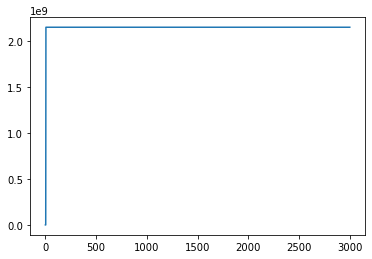

In [19]:
import matplotlib.pyplot as plt
plt.plot(pcs)
plt.show()

In [7]:
print('pc         instr')
n = 500
for pc, instr in zip( pcs[:n], instructions[:n] ): 
    print(f'{pc:<10X} {instr:08X}')

pc         instr
1000       00000297
1004       02028593
1008       F1402573
100C       0182B283
1010       00028067
80000000   00000000
80000004   00029863
80000008   00001117
8000000C   96010113
80000010   0D80006F
800000E8   10500073
800000EC   00113C23
800000F0   00813823
800000F4   02010413
800000F8   00000797
800000FC   05878793
80000100   05878793
80000104   01C0006F
80000120   FE843783
80000124   0007C783
80000128   FE0790E3
80000108   F6DFF0EF
8000010C   00178713
80000110   FEE43423
80000114   0007C783
80000118   00078513
8000011C   F01FF0EF
8000001C   FE843783
80000020   00813C23
80000024   02010413
80000028   00050793
8000002C   FEF407A3
80000030   00000797
80000034   13078793
80000038   0007B783
8000003C   FEF44703
80000040   FEF44703
80000044   00E7A023
80000048   00000013
8000004C   00078513
80000050   01813403
80000054   02010113
80000058   00008067
80000120   FE843783
80000124   0007C783
80000128   FE0790E3
80000108   F6DFF0EF
8000010C   00178713
80000110   FEE43423
800

In [5]:
console_data_available()

True

In [6]:
console_read()

'New program!\n'

In [7]:
console_send('abcdefg')

In [8]:
console_read()

''

In [28]:
console_send('b')

In [8]:
print( len(pcs) )
print( len(instructions) )

3001
3001


In [7]:
base.axi_dma_0.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=0, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=0, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=0, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=0),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=0),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=1, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SG

In [14]:
pcs = []
instructions = []

#while dma_receiver.available():
for i in range(20):
    for pkt in dma_receiver.get():
        pc, instr = unpack_packet(pkt)
        pcs.append(pc)
        instructions.append(instr)

bytes_count=8000
bytes_count=8000
bytes_count=8000
bytes_count=8000
bytes_count=8000
Storage limit reached (out_data length=3000)
bytes_count=8000
Storage limit reached (out_data length=4000)
bytes_count=8000
bytes_count=8000
bytes_count=8000
Storage limit reached (out_data length=3000)
bytes_count=8000
bytes_count=8000
bytes_count=8000
bytes_count=8000
bytes_count=8000
bytes_count=8000
Storage limit reached (out_data length=3000)
bytes_count=8000
bytes_count=8000
bytes_count=8000
bytes_count=8000
Storage limit reached (out_data length=3000)
bytes_count=8000
Storage limit reached (out_data length=4000)
bytes_count=8000
bytes_count=8000
bytes_count=8000
bytes_count=8000
bytes_count=8000
Storage limit reached (out_data length=3000)
bytes_count=8000
Storage limit reached (out_data length=4000)
bytes_count=8000
Storage limit reached (out_data length=5000)
bytes_count=8000
bytes_count=8000
bytes_count=8000
Storage limit reached (out_data length=3000)
bytes_count=8000
Storage limit reached (